In [3]:
import pymc as pm
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [4]:
# get data
API_KEY = os.getenv("API_KEY")
url = 'https://data-service.beatthebookie.blog/data'
headers = {"x-api-key": API_KEY}

# Function to fetch data for a specific division and season
def fetch_data(division, season):
    params = {
        'division': division,
        'season': season
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.read_json(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching {division} {season}: {response.status_code}")
        print(response.content.decode('utf-8'))
        return pd.DataFrame()

# Fetch data for all combinations
seasons = ['2024_2025', '2023_2024']
divisions = ['Premier League', 'Championship']
dataframes = []

for division in divisions:
    for season in seasons:
        df = fetch_data(division, season)
        if not df.empty:
            dataframes.append(df)

# Combine all dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert match_date to datetime
    df['match_date'] = pd.to_datetime(df['match_date'])

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,away_xgoals,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.418711,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Everton - Brighton,6414a61d98ab23b6d757e888ab17a66a,Everton,0d84883ca72c88cb53c8a38262efdcbc,Brighton,...,1.790830,4.0,5.0,18.333333,7.916667,2.63,3.30,2.63,2.00,1.80
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,3.929060,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,1.909150,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,1.954830,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Sunderland - Sheffield Weds,1820e986a8a213df782c5cf5ad0b65e1,Sunderland,ec5c8ee83966ae3a295abeee6ab46871,Sheffield Weds,...,1.300000,NaN,NaN,NaN,NaN,2.70,3.40,2.55,1.80,2.00
1619,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Rotherham - Cardiff,095ea4179483dfdd7fd4ee61a25954f4,Rotherham,288a6430a6f57a76e823d74e0dd750d2,Cardiff,...,1.300000,NaN,NaN,NaN,NaN,3.40,3.40,2.20,1.73,2.10
1620,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Leicester - Blackburn,a06360acafe964d244e424cbd50862e8,Leicester,8178de69a5e17f7bbe3a74331977feb1,Blackburn,...,1.700000,NaN,NaN,NaN,NaN,1.70,3.75,5.25,2.50,1.53
1621,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Plymouth Argyle - Hull,a0111c6b8f3812f2e36ababf2c032d8c,Plymouth Argyle,63b0fc998685327831f96bbe7b07b7e2,Hull,...,0.500000,NaN,NaN,NaN,NaN,3.50,3.75,2.00,2.30,1.62


In [31]:
def build_model(matches_df):
    # Get unique teams
    teams = sorted(set(matches_df['home_team']).union(set(matches_df['away_team'])))
    n_teams = len(teams)
    team_indices = {team: idx for idx, team in enumerate(teams)}
    
    # Create indices for home and away teams
    home_idx = np.array([team_indices[team] for team in matches_df['home_team']])
    away_idx = np.array([team_indices[team] for team in matches_df['away_team']])
    
    # Observed goals
    home_goals = matches_df['home_goals'].values
    away_goals = matches_df['away_goals'].values

    # Calculate days since most recent match
    dates = pd.to_datetime(matches_df['match_date'])
    max_date = dates.max()
    days_since = (max_date - dates).dt.days.values

    n_obs = len(days_since)
    
    with pm.Model() as model:
        #decay_rate = 0.001
        decay_rate = pm.HalfNormal('decay_rate', sigma=0.001)
        
        time_weights = pm.math.exp(-decay_rate * days_since)
        #normalized_weights = time_weights / pm.math.sum(time_weights) * n_obs

        # The rest of your model...
        home_adv = pm.Normal('home_adv', mu=0.25, sigma=0.2)
        attack = pm.ZeroSumNormal('attack', sigma=0.5, shape=n_teams)
        defense = pm.ZeroSumNormal('defense', sigma=0.5, shape=n_teams)

        home_goals_lambda = pm.math.exp(home_adv + attack[home_idx] + defense[away_idx])
        away_goals_lambda = pm.math.exp(attack[away_idx] + defense[home_idx])
        
        # Calculate log probabilities
        home_rv = pm.Poisson.dist(mu=home_goals_lambda)
        away_rv = pm.Poisson.dist(mu=away_goals_lambda)
        
        home_logp = pm.logp(home_rv, home_goals)
        away_logp = pm.logp(away_rv, away_goals)
        
        # Create potentials with weighted sum
        pm.Potential('weighted_home_likelihood', (home_logp * time_weights).sum())
        pm.Potential('weighted_away_likelihood', (away_logp * time_weights).sum())

        os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz-12.2.1-win64\bin'
        graph = pm.model_to_graphviz(model)
        display(graph)

    return model

def sample_model(model, draws=1000, tune=1000, chains=4, cores=None):
    with model:
        trace = pm.sample(draws=draws, tune=tune, chains=chains, cores=cores, return_inferencedata=True)
    return trace


In [32]:
def plot_team_strengths(trace, teams):
    """Plot the attack and defense strengths of teams"""
    attack = az.summary(trace.posterior.attack, kind="stats")["mean"].values
    defense = az.summary(trace.posterior.defense, kind="stats")["mean"].values
    
    # Create a dataframe for plotting
    team_strengths = pd.DataFrame({
        'Team': teams,
        'Attack': attack,
        'Defense': defense
    })
    
    # Sort by attack strength (higher is better)
    team_strengths_attack = team_strengths.sort_values('Attack', ascending=False)
    
    # Sort by defense strength (lower is better)
    team_strengths_defense = team_strengths.sort_values('Defense', ascending=True)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    # Attack plot
    team_strengths_attack.plot.bar(x='Team', y='Attack', ax=ax1, color='skyblue')
    ax1.set_title('Team Attack Strengths')
    ax1.set_ylabel('Attack Parameter (higher is better)')
    ax1.tick_params(axis='x', labelrotation=90)
    
    # Defense plot
    team_strengths_defense.plot.bar(x='Team', y='Defense', ax=ax2, color='salmon')
    ax2.set_title('Team Defense Strengths')
    ax2.set_ylabel('Defense Parameter (lower is better)')
    ax2.tick_params(axis='x', labelrotation=90)
    
    plt.tight_layout()
    return fig


In [33]:
def check_convergence(trace):
    # 1. Summary including R-hat and ESS
    summary = az.summary(trace)
    print("R-hat values > 1.05:")
    print(summary[summary['r_hat'] > 1.05])
    
    # 2. Trace plots
    ax = az.plot_trace(trace, var_names=['home_adv', 'decay_rate', 'attack', 'defense'], 
                      compact=True)
    fig = ax[0, 0].figure
    fig.tight_layout()
    
    # 3. Energy plot
    energy_fig = az.plot_energy(trace)
    
    # 4. Rank plots (checks exchangeability of chains)
    rank_fig = az.plot_rank(trace, var_names=['home_adv'])
    
    # 5. Detailed diagnostics
    diagnostics = {
        'divergences': trace.sample_stats.diverging.sum().item(),
        'min_ess': summary['ess_bulk'].min(),
        'max_rhat': summary['r_hat'].max()
    }
    
    return {
        'summary': summary,
        'trace_fig': fig,
        'energy_fig': energy_fig,
        'rank_fig': rank_fig,
        'diagnostics': diagnostics
    }


In [34]:
def check_goodness_of_fit(trace, teams, test_data):
    team_mapping = {team: idx for idx, team in enumerate(teams)}

    home_idx = np.array([team_mapping[team] for team in test_data["home_team"]])
    away_idx = np.array([team_mapping[team] for team in test_data["away_team"]])

    actual_home_goals = test_data["home_goals"].values
    actual_away_goals = test_data["away_goals"].values

    # For ArviZ InferenceData object:
    home_adv = trace.posterior["home_adv"].values.mean()
    attack = trace.posterior["attack"].values.mean(axis=(0, 1))  # Average across chains and draws
    defense = trace.posterior["defense"].values.mean(axis=(0, 1))

    pred_home_goals = np.exp(home_adv + attack[home_idx] + defense[away_idx])
    pred_away_goals = np.exp(attack[away_idx] + defense[home_idx])

    home_mae = mean_absolute_error(actual_home_goals, pred_home_goals)
    away_mae = mean_absolute_error(actual_away_goals, pred_away_goals)
    combined_mae = (home_mae + away_mae) / 2

    return home_mae, away_mae, combined_mae

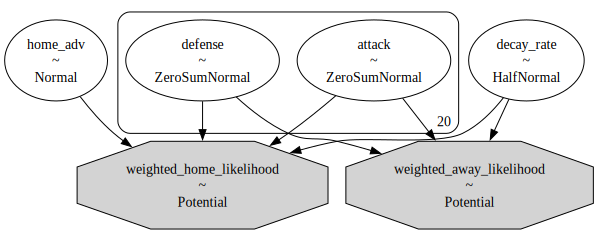

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [decay_rate, home_adv, attack, defense]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 837 seconds.


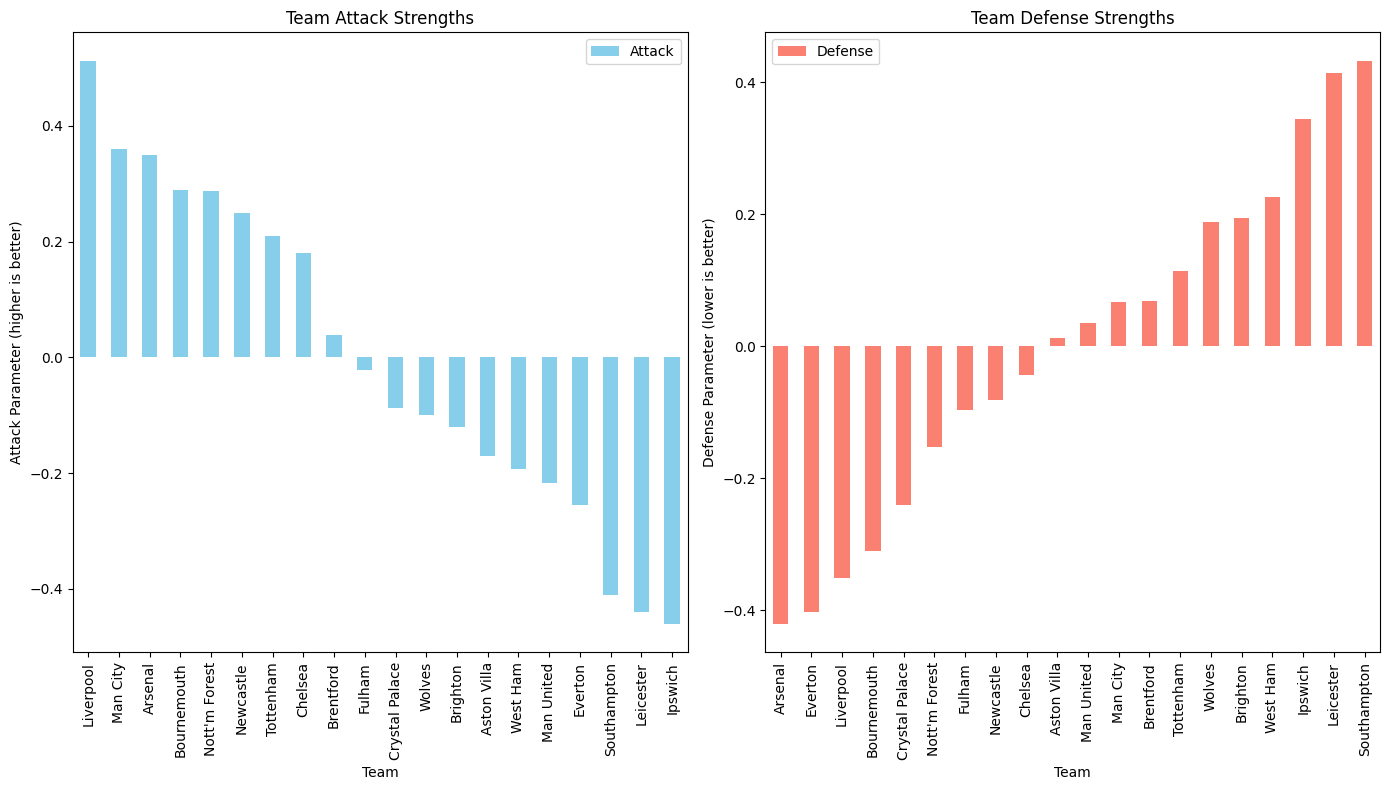

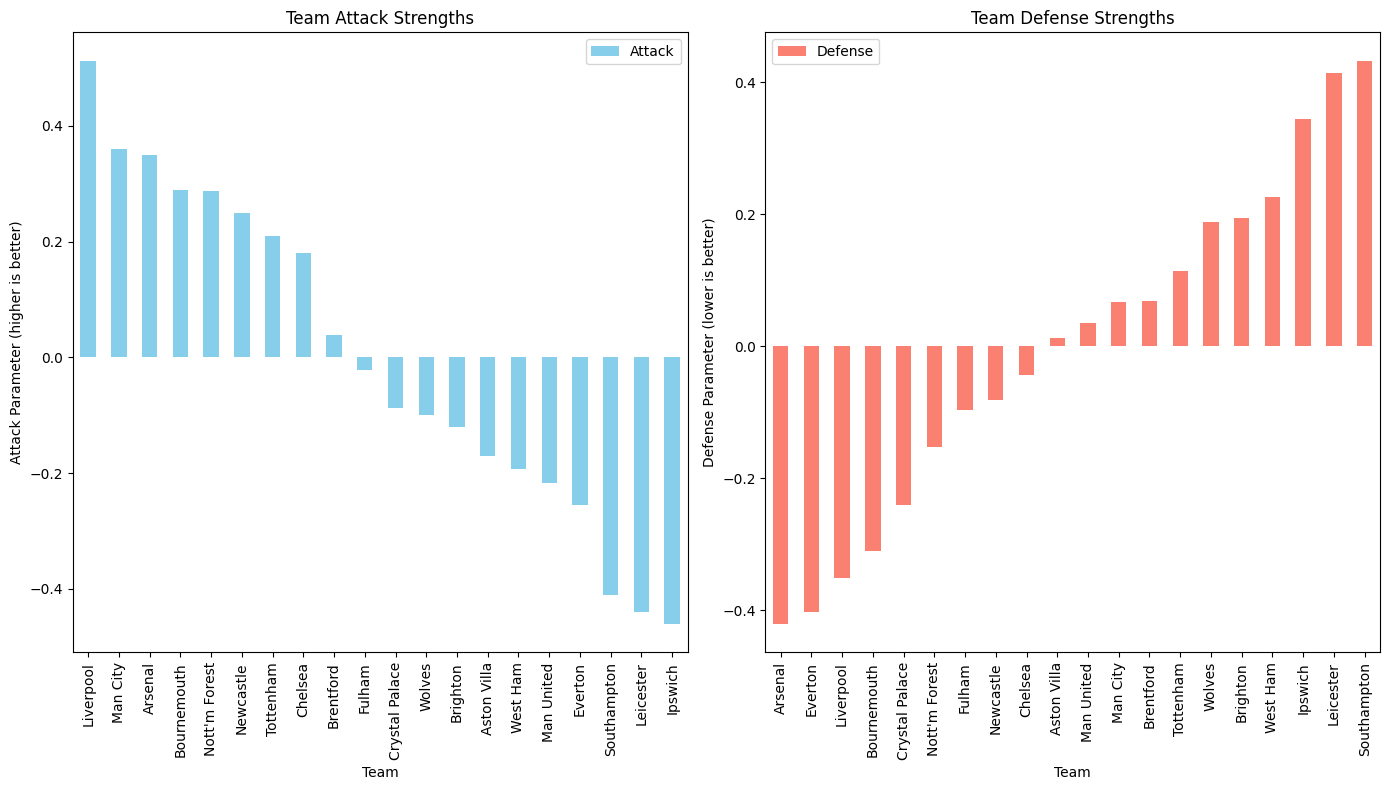

In [35]:
today = datetime.now()
test_cutoff = today - timedelta(days=30)  # Last 30 days for testing
train_cutoff = today - timedelta(days=395)  # Use ~1 year of data for training

train_df = df[(df['match_date'] > train_cutoff) & (df['match_date'] <= test_cutoff)]

# Get Premier League teams present in 2025
year_2025_start = datetime(2025, 1, 1)
teams_in_2025 = set(
    df[(df['match_date'] >= year_2025_start) & (df['division'] == 'Premier League')]['home_team']
).union(
    set(df[(df['match_date'] >= year_2025_start) & (df['division'] == 'Premier League')]['away_team'])
)

# Filter train_df to only include Premier League matches with teams present in 2025
train_df = train_df[train_df['division'] == 'Premier League']
train_df = train_df[
    train_df['home_team'].isin(teams_in_2025) & 
    train_df['away_team'].isin(teams_in_2025)
]

test_df = df[df['match_date'] > test_cutoff]
test_df = test_df[test_df['division'] == 'Premier League']

train_df = train_df[["match_date", "home_team", "away_team", "home_goals", "away_goals"]]

model = build_model(train_df)
trace = sample_model(model, draws=1000, tune=1000, chains=4, cores=multiprocessing.cpu_count())

teams = sorted(set(train_df['home_team']).union(set(train_df['away_team'])))

plot_team_strengths(trace, teams)

R-hat values > 1.05:
Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
{'summary':               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
home_adv     0.302  0.080   0.153    0.454      0.001    0.001    9181.0   
decay_rate   0.015  0.001   0.014    0.016      0.000    0.000   10216.0   
attack[0]    0.349  0.211  -0.041    0.744      0.002    0.002   10686.0   
attack[1]   -0.170  0.254  -0.630    0.306      0.003    0.003    9215.0   
attack[2]    0.289  0.221  -0.123    0.716      0.002    0.002   10064.0   
attack[3]    0.039  0.247  -0.429    0.484      0.003    0.004    9444.0   
attack[4]   -0.120  0.271  -0.617    0.397      0.003    0.004   10165.0   
attack[5]    0.180  0.231  -0.251    0.626      0.002    0.003    8775.0   
attack[6]   -0.087  0.237  -0.553    0.349      0.002    0.004   10534.0   
attack[7]   -0.255  0.260  -0.752    0.220      0.003    0.003    9003.0   
attack[8]   -0.022  0

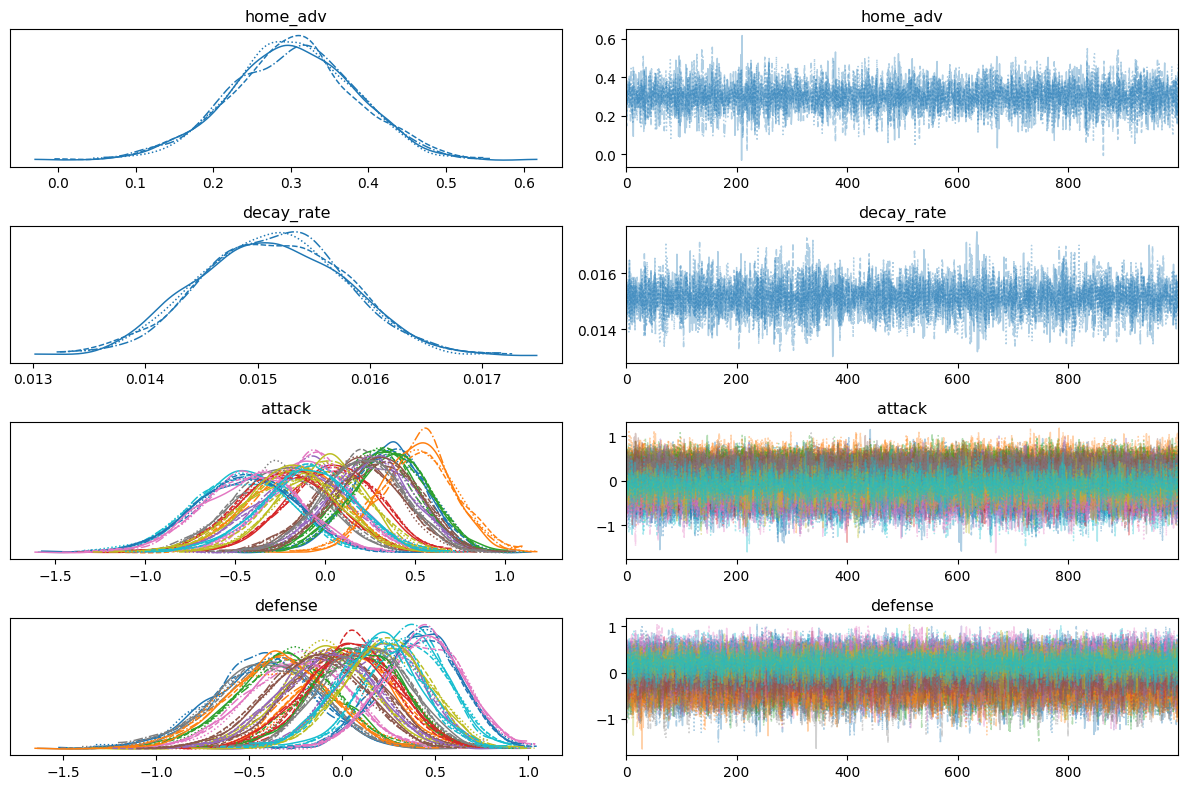

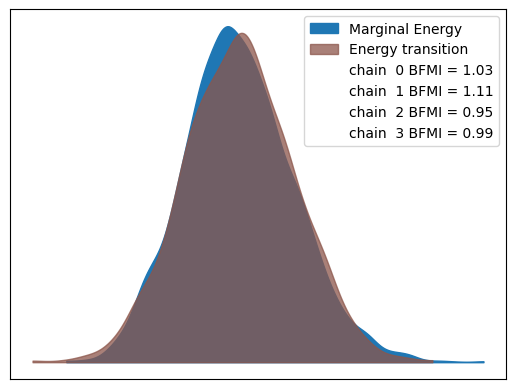

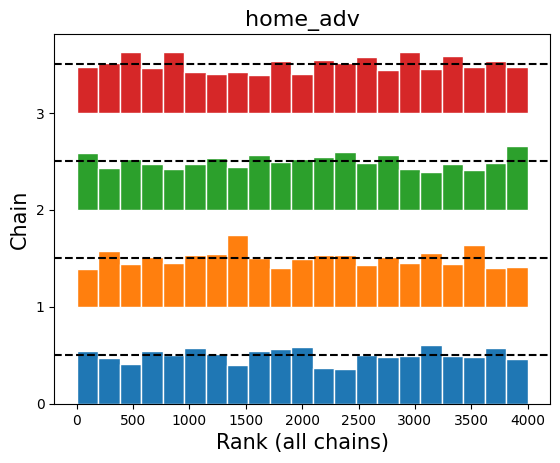

In [36]:
print(check_convergence(trace))

In [37]:
test_df = df[df['match_date'] > test_cutoff]
test_df = test_df[test_df['division'] == 'Premier League']

check_goodness_of_fit(trace, teams, test_df)

(1.1089570068953172, 0.9074791408499646, 1.008218073872641)